In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.colormaps.get('tab10').colors
import torch
import torch_geometric as tg
from gen_autoencoder_dataset import AutoencoderDataset

In [ ]:
n = 500
dataset = AutoencoderDataset(root='autoencoder_graphs', n_graphs_per_type=n)
dataset.process()
train_loader = tg.loader.DataLoader(dataset[:n*12], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*12:], batch_size=16, shuffle=True)
train_loader.dataset[2]
device= 'cuda' if torch.cuda.is_available() else 'cpu'


  0%|          | 0/420 [00:00<?, ?it/s]

100%|██████████| 420/420 [00:02<00:00, 145.75it/s]
c:\Users\steph\VS Code\Python\Computerpraktikum\gen_autoencoder_dataset.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

## New idea: Do on my own

In [ ]:
num_features = dataset.num_features
alpha = 0. # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 3))
        self.encoder.append(tg.nn.GCNConv(3, 2))


        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2, 3))
        self.attr_decoder.append(tg.nn.GCNConv(3, num_features))

        #self.dropout = torch.nn.Dropout(0.2)  
    def forward(self, x, edge_index):
        # encoder
        #print(x.shape, edge_index.shape)
        z = self.encoder[0](x, edge_index).relu()
        #z = self.dropout(z)
        z = self.encoder[1](z, edge_index).relu()
        # decoder
        adj = torch.sigmoid(z @ z.T) # structure decoder

        x_ = self.attr_decoder[0](z, edge_index).relu()
        #x_ = self.dropout(x_)
        x_ = self.attr_decoder[1](x_, edge_index).relu() # attribute decoder
        return x_, adj



model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    # print(f"x shape: {x.shape}, x_ shape: {x_.shape}")
    # print(f"edge_index shape: {edge_index.shape}, adj shape: {adj.shape}")
    #edge_index = edge_index.type(torch.float)
    adj = adj.type(torch.float)
    return alpha * torch.nn.functional.mse_loss(x, x_) + (1-alpha) * torch.nn.functional.mse_loss(adj, adj_)

optimizer = torch.optim.Adam(model.parameters())

dominant(
  (encoder): ModuleList(
    (0): GCNConv(3, 3)
    (1): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 3)
  )
)


In [ ]:
# training:
epochs = 20
train_loss= []
def train(loader):
    model.train()
    avg_loss = 0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return avg_loss / len(loader)
for epoch in range(1, epochs+1):
    loss = train(train_loader)
    train_loss.append(loss)
    print('Epoch: {:03d}, Training Loss: {:.4f}'.format(epoch, loss))

Epoch: 001, Training Loss: 8.4101
Epoch: 002, Training Loss: 8.3885
Epoch: 003, Training Loss: 8.3552
Epoch: 004, Training Loss: 8.1213
Epoch: 005, Training Loss: 8.0574
Epoch: 006, Training Loss: 7.7655
Epoch: 007, Training Loss: 7.3382
Epoch: 008, Training Loss: 7.1533
Epoch: 009, Training Loss: 6.8179
Epoch: 010, Training Loss: 6.7372


4


tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

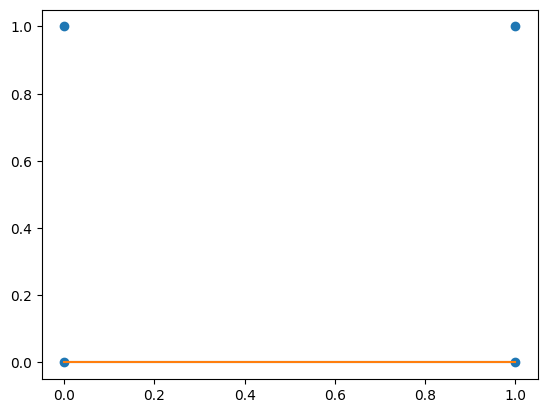

In [12]:
x = np.array([[0,0], [1,0], [0,1], [1,1]])
print(len(x))
edge_index = np.array([[0,1], [1,0]], dtype=np.int64)
fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1])
for i in range(edge_index.shape[1]):
    ax.plot(x[edge_index[:,i],0], x[edge_index[:,i],1], c=cmap[i])
tg.utils.to_dense_adj(torch.tensor(edge_index), max_num_nodes=4)[0]